In [7]:
import json
import os
import ml_collections
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import seisbench_dataloaders as dataloaders



model_config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/model_config_4xdownsample_scale_logits_quantization.json'
training_config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/training_config.json'

with open(model_config_path, "r", encoding="utf-8") as f:
  model_config = json.load(f)
model_config = ml_collections.ConfigDict(model_config)


with open(training_config_path, "r", encoding="utf-8") as f:
  training_config = json.load(f)
training_config = ml_collections.ConfigDict(training_config)


In [9]:
seed_everything(training_config.seed)
model = LitMultiDimWav2Vec2(model_config, training_config)

DEFAULT_NUM_WORKERS = 4

data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=model_config,
      mask_time_prob=training_config.mask_time_prob,
      mask_time_length=training_config.mask_time_length,
  )


training_config.num_workers = int(
  os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS))

train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
  model=model,
  training_fraction=training_config.training_fraction,
  data_names=training_config.data_name,
  batch_size=training_config.local_batch_size,
  num_workers=training_config.num_workers,
  prefetch_factor=training_config.prefetch_factor,
  collator=data_collator,
  cache=training_config.cache_dataset,
)



Seed set to 42
2024-07-26 10:50:08,881 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-07-26 10:50:56,729 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
/scicore/home/dokman0000/liu0003/anaconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self._metadata["trace_dataset"] = sum(
/scicore/home/dokman0000/liu0003/anaconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  T

In [10]:
import matplotlib.pyplot as plt

In [11]:
batch = next(iter(train_loader))

In [17]:
batch['input_values'].shape

torch.Size([28, 3, 3001])

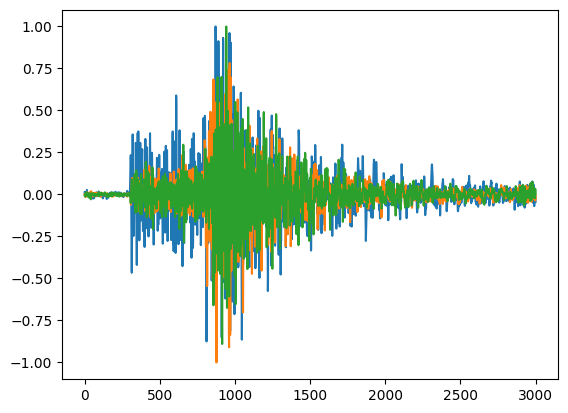

In [15]:
idx = 0

plt.plot(batch['input_values'][0].T)

In [16]:
len(train_loader)

105152